---
Relevance maximization
---


**Description:**  
Selection of Channels which have great influence on the prediction
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [1]:
import os
import io
import sys
import torch
import random
from PIL import Image
from pathlib import Path
from crp.image import imgify
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))

from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel
from sentinelmodels.preprocessing import SentinelDataset
from interpet.concept.conceptrelevance import ConceptRelevance

In [3]:
config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "symmetric":False,
                "level":1
                }

datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/wilderness_data.pkl"

loaded_data = dictionary = load_dict(datafilepath)
# Accessing the loaded images and labels
images = loaded_data["images"][-1,:,:,:].unsqueeze(dim=0).to(config["device"])
#images = loaded_data["images"].to(config["device"])

labels = loaded_data["labels"]

input_image_name="wilderness_data_relmax.png"
image_path = os.path.join(r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/",input_image_name)
save_image(F.pad(images, (2, 2, 2, 2), mode='constant', value=0), image_path, nrow=1, padding=0)

In [4]:
modelindex=-1
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])
Concepts=ConceptRelevance(model,device=config["device"])
del model

In [5]:
recordlayers=list(Concepts.layer_map.keys())
print(recordlayers)

['features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'common_layers.0', 'common_layers.3', 'common_layers.6']


In [6]:
heatmap,relevance,p=Concepts.conditional_relevance(images,condition=[{"y":[1]}],compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=recordlayers)

In [7]:
topk_c=5
toprelevance_list=Concepts.compute_relevance_maximization(relevance,condlayernames=recordlayers,relevance_type="positive",topk_c=topk_c)

In [8]:
toprelevance_list["features.7.1.conv1"]

[([485, 154, 259, 291, 241],
  [2.8653275966644287,
   2.745089292526245,
   2.4069247245788574,
   2.2167999744415283,
   2.1922295093536377])]

In [8]:
def generate_maxconcepts(images,layername,channelindexlist,output=[1],compositename="epsilonplus",canonizerstype="vgg16",output_type="max",record_layer=[]):
    concepthm=[]
    for i in range(0,len(channelindexlist)):
        conditions=[]
        conditions += [{"y": output, layername: [channel]} for channel in channelindexlist[i][0]]
        reldheatmap,_,_=Concepts.conditional_relevance(images,condition=conditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        selectedhmconditions = [{"y": output, layername:channelindexlist[i][0]}]
        selectedcondheatmap,scm_relevance,_=Concepts.conditional_relevance(images[i,:,:,:].unsqueeze(dim=0),condition=selectedhmconditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        concepthm.append((reldheatmap,selectedcondheatmap,scm_relevance))
    return concepthm

In [16]:
layername=recordlayers[-5]
print(layername)
relevancetype="positive" #["abs","positive","negative"]

features.7.1.conv1


In [17]:
batchmaxconcept=generate_maxconcepts(images,layername,channelindexlist=toprelevance_list[layername],output=[1],compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type=relevancetype,record_layer=[layername])

In [18]:
batchsize=images.shape[0]
print(batchsize)
if batchsize==1:
    index=0
    initialheatmap=imgify(heatmap,cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])
else:
    index=0
    initialheatmap=imgify(heatmap[index,:,:].unsqueeze(dim=0),cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])

1


In [19]:
layerconcepthm={}
for i in  range(0,len(batchmaxconcept[index][0])):
    hm=batchmaxconcept[index][0][i,:,:].unsqueeze(dim=0)
    layerconcepthm[toprelevance_list[layername][index][0][i]]=(imgify(hm,cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"]),toprelevance_list[layername][index][1][i])

In [20]:
from crp.image import vis_opaque_img
for i in  range(0,len(batchmaxconcept[index][0])):
    hm=batchmaxconcept[index][0][i,:,:].unsqueeze(dim=0)
    layerconcepthm[str(toprelevance_list[layername][index][0][i])+" mask"]=(vis_opaque_img(images,hm,alpha=0.15,kernel_size=13)[0],0.0)

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


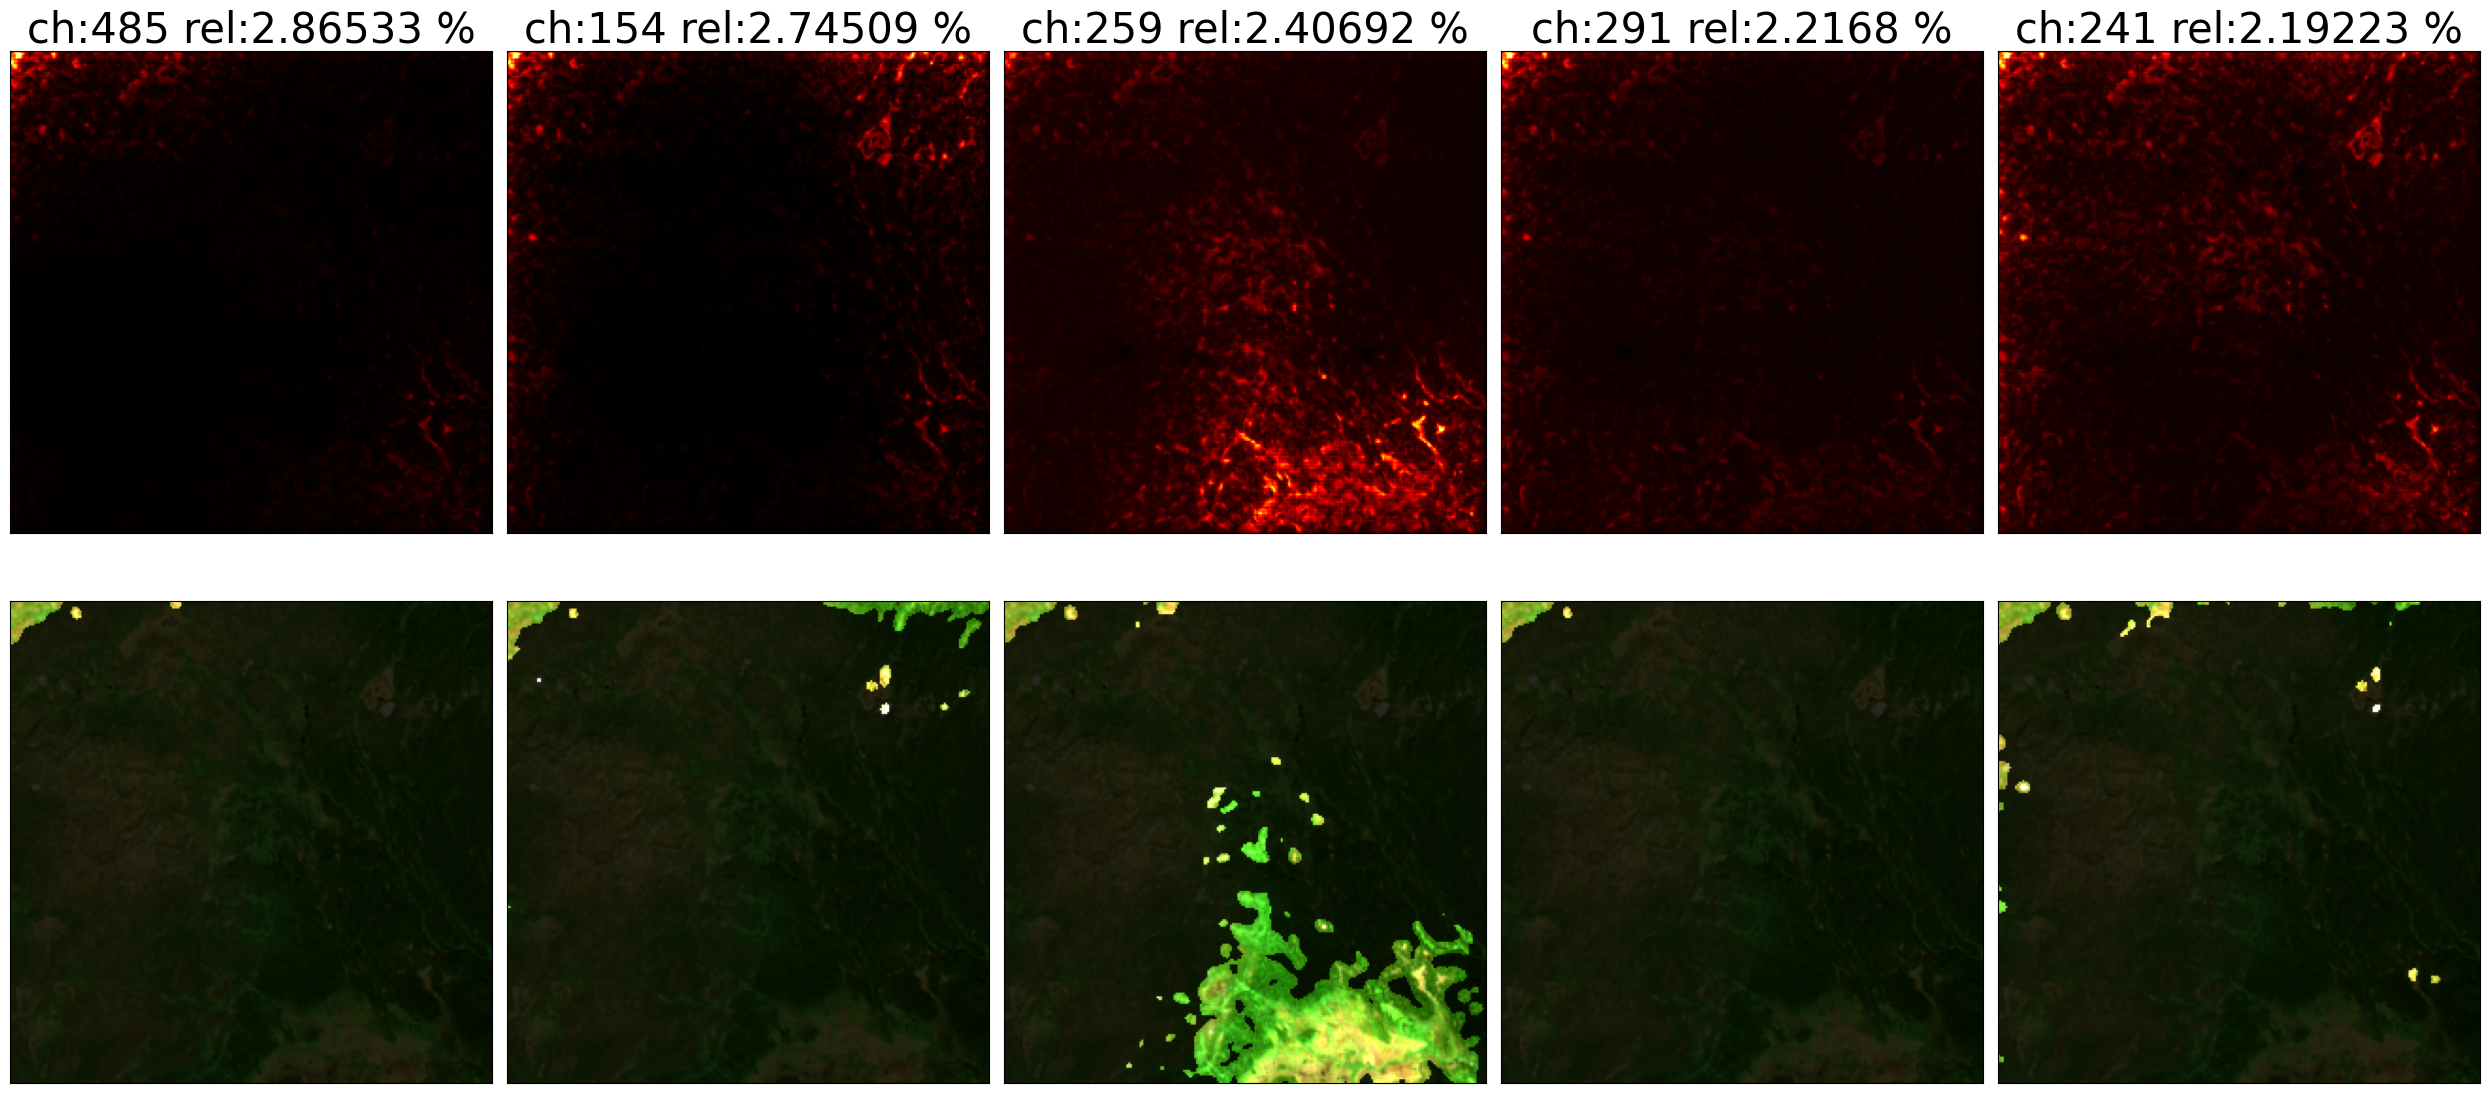

In [21]:
grid_rows = 2
grid_cols = int(len(list(layerconcepthm.keys()))/2)
fontsize=30
# Create a figure and a set of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(25, 12))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cum_sum=0
# Iterate over the images and the axes
for i, (key, (img, val)) in enumerate(layerconcepthm.items()):
    # Plotting the PIL image
    axes[i].imshow(img)
    if "mask" in str(key):
        cum_sum+=0
        title = f""
    else:
        cum_sum+=val
        title = f"ch:{key} rel:{round(val,5)} %"
    # Adding a title
      # Convert tensor to scalar
    axes[i].set_title(title,fontsize=fontsize,color='black')

    # Turn off axis
    axes[i].axis('on')
    axes[i].get_yaxis().set_visible(False)
    axes[i].get_xaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png',dpi=600)
buf.seek(0)

# Create a PIL image from the buffer
pil_img = Image.open(buf)
#plt.close()

In [22]:
neagtivetoprelevance_list=Concepts.compute_relevance_maximization(relevance,condlayernames=recordlayers,relevance_type="negative",topk_c=5)

In [23]:
notmaxcondition=[{"y":[1],layername:neagtivetoprelevance_list[layername][index][0]}]
maxcondition=[{"y":[1],layername:[i for i in range(relevance[layername].shape[1]) if i not in toprelevance_list[layername][index][0]]}]

In [24]:
topnegativeheatmap,_,p=Concepts.conditional_relevance(images,condition=notmaxcondition,compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=recordlayers)

In [28]:
notmaxheatmapimg=imgify(topnegativeheatmap,cmap="france", symmetric=True,level=2)
meanreal=topnegativeheatmap.sum()

In [25]:
maxheatmap,_,p=Concepts.conditional_relevance(images,condition=maxcondition,compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=recordlayers)

In [27]:
maxheatmapimg=imgify(batchmaxconcept[index][1],cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])
maxmeanreal=batchmaxconcept[index][1].sum()

In [26]:
topnegativemaximg=vis_opaque_img(images,abs(topnegativeheatmap),alpha=0.0,kernel_size=5)[0]
withonlymaximg=vis_opaque_img(images,abs(batchmaxconcept[index][1]),alpha=0.0,kernel_size=19)[0]

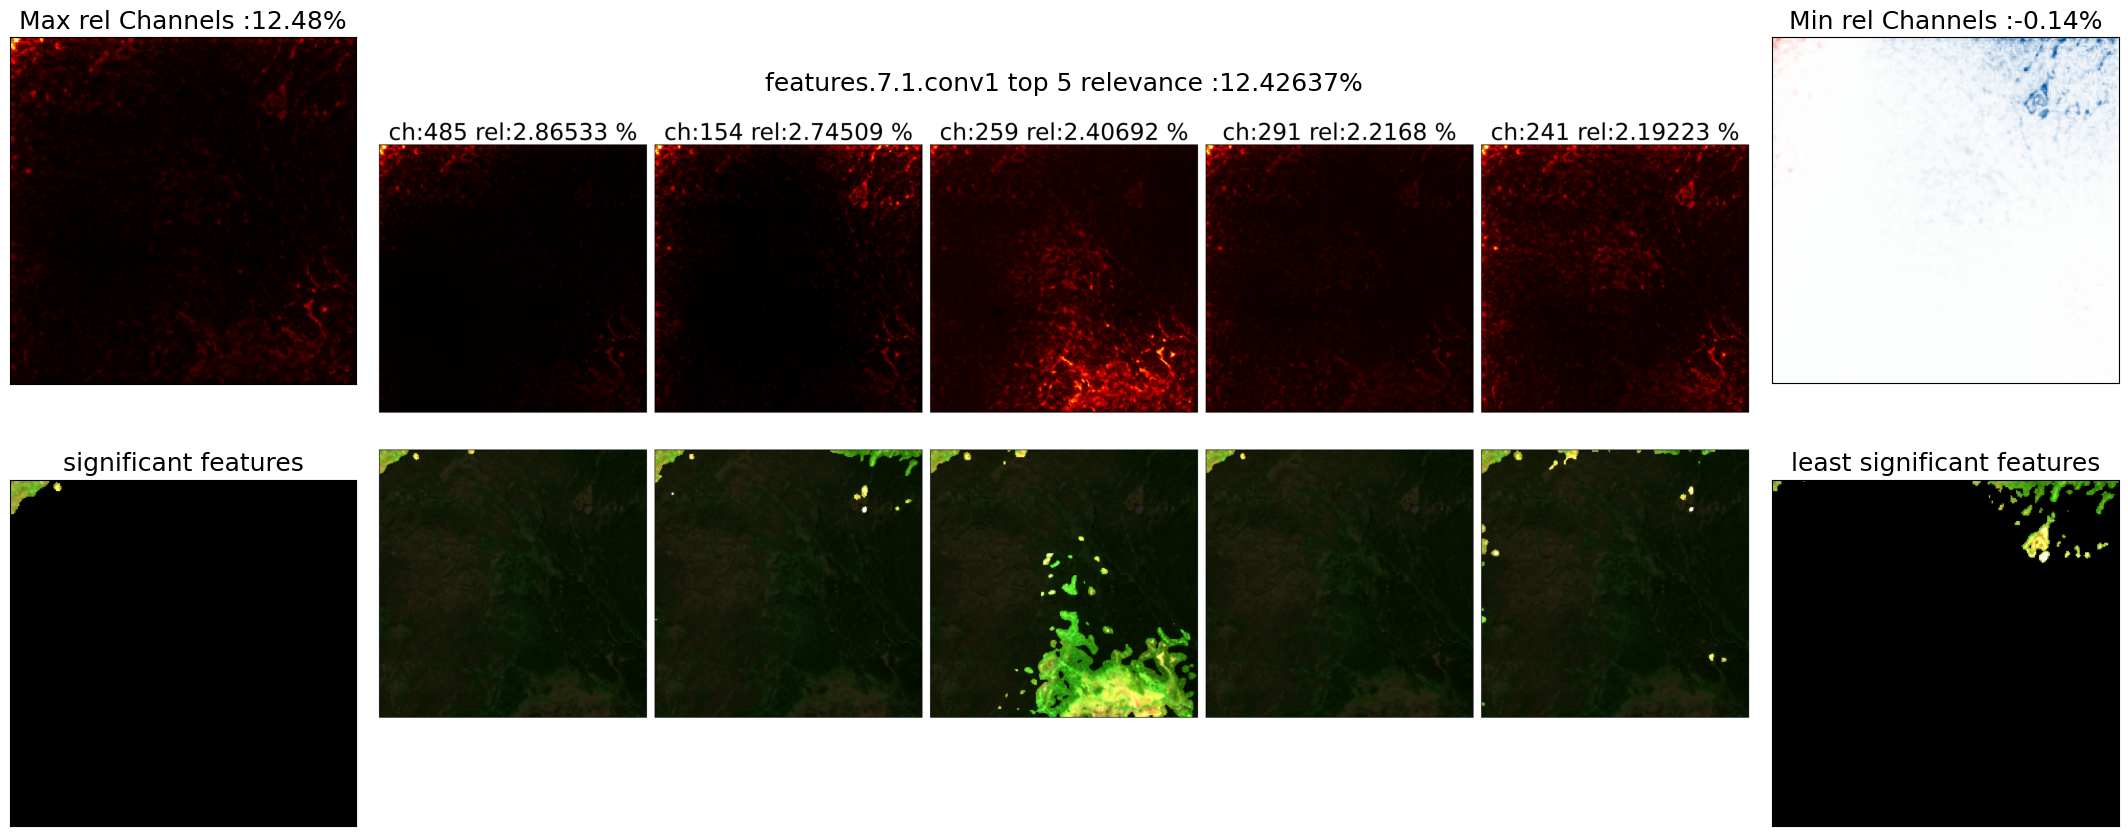

In [31]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Assuming image1, image2, image3, image4 are your smaller images and large_image is your larger one
# Replace these with your actual image variables

fig = plt.figure(figsize=(25, 9))  # Create a figure with a custom size
fontsize=18
# Create a GridSpec layout
gs = GridSpec(2, 4, figure=fig,width_ratios=[1, 4, 1, 1])  # 2 rows, 5 columns

# Place the smaller images in the first and last columns (2x1 layout)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(maxheatmapimg)
ax1.set_title("Max rel Channels :"+str(round(maxmeanreal.item()*100,2))+"%",fontsize=fontsize)
ax1.axis('on')
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)

ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(withonlymaximg)
#ax2.set_title("Predicited class:"+str(withmaxpredictionclass.item())+" (1)",fontsize=fontsize)
ax2.set_title("significant features",fontsize=fontsize)
ax2.axis('on')
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

# Place the larger image in the middle column, spanning two rows
ax3 = fig.add_subplot(gs[:, 1])  # This will span columns 2 and 3
ax3.set_title(layername+" top "+str(topk_c)+" relevance :"+str(round(cum_sum,5))+"%",fontsize=fontsize)
ax3.imshow(pil_img)  # Replace with your larger image
ax3.axis('off')


# Place the other two smaller images in the last column (2x1 layout)
ax4 = fig.add_subplot(gs[0, 2])
ax4.imshow(notmaxheatmapimg)
ax4.set_title("Min rel Channels :"+str(round(meanreal.item()*100,2))+"%",fontsize=fontsize)
ax4.axis('on')
ax4.get_yaxis().set_visible(False)
ax4.get_xaxis().set_visible(False)

ax5 = fig.add_subplot(gs[1, 2])
ax5.imshow(topnegativemaximg)
ax5.set_title("least significant features",fontsize=fontsize)
ax5.axis('on')
ax5.get_yaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)


plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_"+layername+"_toprel_concepts.png"),dpi=600)
plt.show()